# Importing the required modules

In [38]:
# Modules for data manipulation and visualisation.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Module for handling json documents.
import json

# Modules for the NER and its customisation.
import spacy
from spacy.util import minibatch, compounding
from spacy.training.example import Example
from pathlib import Path

# Module for matching regular expressions.
import re

# Module for suppressing warnings.
import warnings 
warnings.filterwarnings('ignore')

# Module for random sampling for training data.
import random

# Question Input

In [91]:
qs = input()

# Intent Classification

In [92]:
file = open(r"..\data\intent_classification_data.json")
data = json.load(file)

In [93]:
data

{'TrainCheck': ['Is X the train number of Y?', 'Does X have train number Y?'],
 'RouteCheck': ['Are X and Y connected by rail?',
  'Is there a train connecting X and Y?']}

In [94]:
intent_similiarity = dict()

In [95]:
def question_similiarity(sentence,question):
    nlp = spacy.load("en_core_web_sm")
    sent = nlp(sentence)
    q = nlp(question)
    return sent.similarity(q)

In [96]:
for i in data:
    intent_similiarity[i] = np.mean(list(map(question_similiarity,data[i],[qs]*len(data[i]))))
print(intent_similiarity)

{'TrainCheck': 0.708569796852156, 'RouteCheck': 0.466522582615974}


# Entity Recognition

## Preparing training data

### Reading the dataset

In [ ]:
trains = pd.read_csv("..\data\All_Indian_Trains.csv")

In [ ]:
trains.head()

,Unnamed: 0,Train no.,Train name,Starts,Ends
0,0,12723,Andhra Pradesh Express,Hyderabad Decan,New Delhi
1,1,22416,Andhra Pradesh Express,New Delhi,Vishakapatnam
2,2,12724,Andhra Pradesh Express,New Delhi,Hyderabad Decan
3,3,12707,Andhra Pradesh Sampark Kranti,Tirupati,H Nizamuddin
4,4,15909,Abadh Assam Express,New Tinsukia Junction,Darbhanga Junction


In [ ]:
trains = trains.drop(["Unnamed: 0"],axis=1)

In [ ]:
trains.head()

,Train no.,Train name,Starts,Ends
0,12723,Andhra Pradesh Express,Hyderabad Decan,New Delhi
1,22416,Andhra Pradesh Express,New Delhi,Vishakapatnam
2,12724,Andhra Pradesh Express,New Delhi,Hyderabad Decan
3,12707,Andhra Pradesh Sampark Kranti,Tirupati,H Nizamuddin
4,15909,Abadh Assam Express,New Tinsukia Junction,Darbhanga Junction


### Seggragating different forms of questions

In [ ]:
num2name = data["TrainCheck"][0]
name2number = data["TrainCheck"][1]
route_check = data["RouteCheck"]

### All the available unique entities in the dataset

In [ ]:
all_train_nos = list(set(trains["Train no."]))
all_train_names = list(set(trains["Train name"]))
all_stations = list(set(list(trains["Starts"])+list(trains["Ends"])))

### Data Augmentation

In [ ]:
training_data = []

#### Randomly sampling 20 entries of train numbers and names

In [ ]:
train_nos_sampled = random.sample(all_train_nos,20)

In [ ]:
train_names_sampled = random.sample(all_train_names,20)

#### Creating training data for TrainCheck

In [ ]:
for i in list(zip(train_nos_sampled,train_names_sampled)):
    prepared_str = num2name.replace("X",str(i[0])).replace("Y",i[1])
    training_data.append((prepared_str,{"entities":[getFirstMatch(str(i[0]),prepared_str,"CARDINAL"),getFirstMatch(i[1],prepared_str,"FAC")]}))

In [ ]:
for i in list(zip(train_nos_sampled,train_names_sampled)):
    prepared_str = name2number.replace("Y",str(i[0])).replace("X",i[1])
    training_data.append((prepared_str,{"entities":[getFirstMatch(str(i[0]),prepared_str,"CARDINAL"),getFirstMatch(i[1],prepared_str,"FAC")]}))

#### Creating training data for RouteCheck

In [ ]:
for i in range(10):
    for qs in route_check:
        station1 = random.choice(all_stations)
        station2 = random.choice(all_stations)
        prepared_str = qs.replace("X",station1).replace("Y",station2)
        training_data.append((prepared_str,{"entities":[getFirstMatch(station1,prepared_str,"GPE"),getFirstMatch(station2,prepared_str,"GPE")]}))

#### Storing the generated training data in a json document

In [ ]:
with open(r'..\data\ner_training_data.json', 'w') as f:
    json.dump({"training_data":training_data}, f)

## Fine tuning the NER pipeline

### Loading the training data

In [ ]:
training_data = json.load(open(r"..\data\ner_training_data.json","r"))

In [ ]:
training_data = training_data["training_data"]

In [ ]:
nlp = spacy.load("en_core_web_sm")
ner = nlp.get_pipe("ner")

In [ ]:
for _, annotations in training_data:
  for ent in annotations.get("entities"):
    ner.add_label(ent[2])

In [ ]:
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

In [ ]:
l = []
with nlp.disable_pipes(*unaffected_pipes):
  for iteration in range(60):
    random.shuffle(training_data)
    losses = {}
    batches = minibatch(training_data, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        for text, annotations in batch:
         doc = nlp.make_doc(text)
         example = Example.from_dict(doc, annotations)
         nlp.update(
                    [example],
                    drop=0.5,
                    losses=losses,
                )
        l.append(losses["ner"])

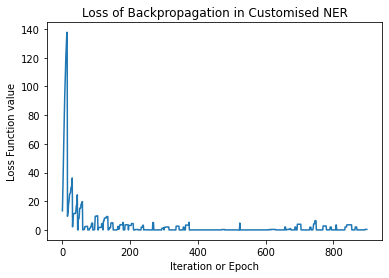

In [ ]:
plt.plot(list(range(len(l))),l)
plt.xlabel("Iteration or Epoch")
plt.ylabel("Loss Function value")
plt.title("Loss of Backpropagation in Customised NER")
plt.show()

In [ ]:
nlp.to_disk("../models/railways_ner")

In [72]:
entities = nlp(qs).ents
entities_with_labels = []

In [73]:
for i in entities:
    entities_with_labels.append((i.label_,i.text))

In [74]:
entities_with_labels

[('CARDINAL', '9427'), ('FAC', 'Adi Ald Special')]

# Question Answering

### Column-Intent Mapping

In [97]:
column_intent_mapping = {
    "TrainCheck":["Train no.","Train name"],
    "RouteCheck":["Starts","Ends"]
}

### Intent Extraction

In [98]:
intent_similiarity

{'TrainCheck': 0.708569796852156, 'RouteCheck': 0.466522582615974}

In [99]:
intent = max(zip(intent_similiarity.values(), intent_similiarity.keys()))[1]
print(intent)

TrainCheck


In [100]:
relevant_columns = column_intent_mapping[intent]

In [101]:
trains = pd.read_csv("..\data\All_Indian_Trains.csv")

In [102]:
search_space = trains[relevant_columns]

In [103]:
dict(entities_with_labels)

{'CARDINAL': '9427', 'FAC': 'Adi Ald Special'}

In [104]:
if intent == "RouteCheck":
   search_results = search_space.loc[(search_space['Starts'] == entities_with_labels[0][1]) & (search_space['Ends'] == entities_with_labels[1][1])]
else:
   entities_with_labels = dict(entities_with_labels)
   search_results = search_space.loc[(search_space['Train no.'] == int(entities_with_labels["CARDINAL"])) & (search_space['Train name'] == entities_with_labels["FAC"])]

In [105]:
response = "No"
if len(search_results) > 0:
    response = "Yes"

In [106]:
response

'Yes'